# Фаза 2 • Неделя 8 • Понедельник
## Нейронные сети
### 🔥 PyTorch

In [152]:
# PyTorch-инференс и сохранение сабмишна (вместо .predict у sklearn)

def predict_and_save_torch(model: nn.Module, X_tensor: torch.Tensor, test_ids: np.ndarray, filename: str = "submission.csv", device: str | torch.device | None = None) -> pd.DataFrame:
    """Делает предсказания лог-цен через PyTorch-модель, переводит их обратно из log1p,
    сохраняет CSV и возвращает DataFrame сабмишна.

    Аргументы:
        model: обученная PyTorch-модель
        X_tensor: тензор признаков теста (тот, что вернула prepare_test_torch)
        test_ids: массив Id (например, test["Id"].values или test_df_proc.index.values)
        filename: имя файла для сохранения
        device: cuda/cpu; если None — берём из параметров модели
    """
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    with torch.inference_mode():
        preds_log = model(X_tensor.to(device)).squeeze(1).cpu().numpy()  # (N,)

    y_test = np.expm1(preds_log)  # обратное к log1p
    submission = pd.DataFrame({"Id": test_ids, "SalePrice": y_test})
    submission.to_csv(filename, index=False)
    print(f"Saved: {filename}")
    return submission

# Пример использования для текущего ноутбука:
# test_ids = test["Id"].values
# sub = predict_and_save_torch(model_sig_inside, X_te, test_ids, filename="submission.csv")
# sub.head()
import torch
torch.manual_seed(42)
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import torchutils as tu

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler

In [4]:
train = pd.read_csv('/Users/fyodor/Desktop/Edu/ds_bootcamp/ds-phase-2/08-nn/aux/train.csv')
test = pd.read_csv('/Users/fyodor/Desktop/Edu/ds_bootcamp/ds-phase-2/08-nn/aux/test.csv')


### Оценка стоимости недвижимости с применением нейронных сетей

Загрузите датасет House Prices (https://www.kaggle.com/c/house-prices-advanced-regression-techniques) с прошлой недели: датасет должен быть предобработанный:

* в нем должны отсутствовать пропуски
* данные **обязательно** должны быть нормализованы
* целевая переменная должна быть логарифмирована
* в `TensorDataset` передаем только массив, а не `DataFrame` 

In [5]:
pd.DataFrame({'nan': train.isna().sum()}).sort_values(ascending=False, by='nan')

,nan
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
...,...
ExterQual,0
Exterior2nd,0
Exterior1st,0
RoofMatl,0


In [6]:
df = train.copy()
df = df.set_index('Id')

In [7]:
NUMERIC_FEATURES = [
    'LotArea', 'GrLivArea', 'BsmtUnfSF', '1stFlrSF', 'TotalBsmtSF', 'SalePrice',
    'BsmtFinSF1', 'GarageArea', '2ndFlrSF', 'MasVnrArea', 'WoodDeckSF', 'OpenPorchSF',
    'BsmtFinSF2', 'EnclosedPorch', 'LotFrontage', 'ScreenPorch', 'TotRmsAbvGrd',
    'OverallQual', 'OverallCond', 'BedroomAbvGr', 'PoolArea', 'GarageCars', 'Fireplaces',
    'KitchenAbvGr', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BsmtHalfBath', 'YearBuilt',
    'YearRemodAdd', 'LowQualFinSF', 'MiscVal'
]

CAT_FEATURES = [
    'MSSubClass', 'YrSold', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
    'LotConfig', 'Neighborhood', 'LandSlope', 'Condition1', 'BldgType', 'HouseStyle',
    'RoofStyle', 'Exterior1st', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
    'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType1', 'HeatingQC', 'Electrical',
    'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'SaleType',
    'SaleCondition'
]

FOR_LOG = [
    'LotArea', 'GrLivArea', 'BsmtUnfSF', '1stFlrSF', 'TotalBsmtSF',
    'BsmtFinSF1', 'GarageArea', '2ndFlrSF', 'MasVnrArea',
    'WoodDeckSF', 'OpenPorchSF', 'BsmtFinSF2', 'EnclosedPorch',
    'LotFrontage', 'ScreenPorch'
]

TYPESTR = ['MSSubClass', 'YrSold']

FOR_DROP = [
    'Utilities', 'Condition2', 'RoofMatl', 'Exterior2nd', 'BsmtFinType2', 'Heating', 'GarageCond', 'GarageQual', 'Fence'
]

WORST_FEATURES = [
    'ScreenPorch','HasLotFrontage','HasMasVnr','Has2ndFlr','HasGarageYrBlt',
    'HasTotalBsmtSF','HasBsmtUnfSF','HasBsmtFinSF2','WoodDeckSF','EnclosedPorch',
    'BsmtHalfBath','HasBsmtFullBath','PoolQC','MiscFeature','KitchenAbvGr',
    'Street','MiscVal','PoolArea','3SsnPorch','LowQualFinSF'
]

In [8]:
def prepare_train(df: pd.DataFrame):
    """Готовит данные под PyTorch: лог-трансформация таргета, one-hot для категориальных,
    стандартизация признаков и возврат тензоров + артефактов для теста."""

    # 1) базовая копия и индекс
    df = df.copy()
    df = df.set_index('Id')

    # 2) заполнения пропусков (как раньше)
    df["Alley"] = df["Alley"].fillna("NoAlley")
    df["MasVnrType"] = df["MasVnrType"].fillna("None")
    df["BsmtQual"] = df["BsmtQual"].fillna("NoBsmt")
    df["BsmtCond"] = df["BsmtCond"].fillna("NoBsmt")
    df["BsmtExposure"] = df["BsmtExposure"].fillna("NoBsmt")
    df["BsmtFinType1"] = df["BsmtFinType1"].fillna("NoBsmt")
    df["Electrical"] = df["Electrical"].fillna("SBrkr")
    df["FireplaceQu"] = df["FireplaceQu"].fillna("NoFireplace")
    df["GarageType"] = df["GarageType"].fillna("NoGarage")
    df["GarageFinish"] = df["GarageFinish"].fillna("NoGarage")
    df["PoolQC"] = df["PoolQC"].fillna("NoPool")
    df["MiscFeature"] = df["MiscFeature"].fillna("None")
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
    df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

    # 3) лог-признаки
    for col in FOR_LOG:
        df[f"{col}_log"] = np.log1p(df[col])

    # 4) лог-таргет (регрессия по log(SalePrice))
    df['SalePrice'] = np.log1p(df['SalePrice'])

    # 5) приведение типов-строк
    for col in TYPESTR:
        if col in df.columns:
            df[col] = df[col].astype(str)

    # 6) бинарные флаги
    df["HasTotalBsmtSF"] = (df["TotalBsmtSF"] > 0).astype(int)
    df["HasBsmtUnfSF"]   = (df["BsmtUnfSF"] > 0).astype(int)
    df["HasBsmtFinSF1"]  = (df["BsmtFinSF1"] > 0).astype(int)
    df["HasBsmtFinSF2"]  = (df["BsmtFinSF2"] > 0).astype(int)
    df["HasBsmtFullBath"] = (df["BsmtFullBath"] > 0).astype(int)

    df["HasGarageArea"] = (df["GarageArea"] > 0).astype(int)
    df["HasGarageYrBlt"] = (~df["GarageYrBlt"].isna()).astype(int)

    df["Has2ndFlr"] = (df["2ndFlrSF"] > 0).astype(int)

    df["HasMasVnr"] = (df["MasVnrArea"] > 0).astype(int)

    df["WoodDeckSF"]    = (df["WoodDeckSF"] > 0).astype(int)
    df["EnclosedPorch"] = (df["EnclosedPorch"] > 0).astype(int)
    df["ScreenPorch"]   = (df["ScreenPorch"] > 0).astype(int)
    df["3SsnPorch"]     = (df["3SsnPorch"] > 0).astype(int)

    df["HasLotFrontage"] = (~df["LotFrontage"].isna()).astype(int)

    df["PoolArea"]    = (df["PoolArea"] > 0).astype(int)
    df["MiscVal"]     = (df["MiscVal"] > 0).astype(int)
    df["LowQualFinSF"] = (df["LowQualFinSF"] > 0).astype(int)
    df["PavedDrive"] = (df["PavedDrive"] == "Y").astype(int)
    df["PoolQC"] = (df["PoolQC"] != "NoPool").astype(int)
    df["MiscFeature"] = (df["MiscFeature"] != "None").astype(int)

    df["HasFireplace"] = (df["Fireplaces"] > 0).astype(int)

    df["CentralAir"] = (df["CentralAir"] == "Y").astype(int)

    # 7) выброс лишних столбцов
    df = df.drop(columns=FOR_DROP)

    # 8) разбиение на X / y
    X = df.drop(columns=['SalePrice'])
    y = df['SalePrice'].values.astype(np.float32)

    # 9) удалить наихудшие фичи, если они присутствуют
    drop_cols = [c for c in WORST_FEATURES if c in X.columns]
    if drop_cols:
        X = X.drop(columns=drop_cols)

    # 10) категориальные → строки + заполнение, затем one-hot
    cat_cols = [c for c in CAT_FEATURES if c in X.columns]
    if cat_cols:
        X[cat_cols] = X[cat_cols].fillna("__MISSING__").astype(str)
        X = pd.get_dummies(X, columns=cat_cols, sparse=False)

    # 11) стандартизация признаков
    scaler = StandardScaler()
    X_values = X.values.astype(np.float32)
    X_scaled = scaler.fit_transform(X_values).astype(np.float32)

    # 12) преобразование в тензоры PyTorch
    X_tensor = torch.from_numpy(X_scaled)
    y_tensor = torch.from_numpy(y).view(-1, 1)

    # Возвращаем также артефакты для подготовки теста
    return df, X_tensor, y_tensor, X.columns, scaler


In [9]:
def prepare_test_torch(test_df: pd.DataFrame, X_columns: pd.Index, train_df: pd.DataFrame, scaler):
    """Готовит тест под PyTorch по тем же правилам и выравнивает столбцы как у train; возвращает тензор X и подготовленный df."""

    df = test_df.copy()
    df = df.set_index('Id')

    # такие же заполнения, как в train
    df["Alley"] = df["Alley"].fillna("NoAlley")
    df["MasVnrType"] = df["MasVnrType"].fillna("None")
    df["BsmtQual"] = df["BsmtQual"].fillna("NoBsmt")
    df["BsmtCond"] = df["BsmtCond"].fillna("NoBsmt")
    df["BsmtExposure"] = df["BsmtExposure"].fillna("NoBsmt")
    df["BsmtFinType1"] = df["BsmtFinType1"].fillna("NoBsmt")
    df["Electrical"] = df["Electrical"].fillna("SBrkr")
    df["FireplaceQu"] = df["FireplaceQu"].fillna("NoFireplace")
    df["GarageType"] = df["GarageType"].fillna("NoGarage")
    df["GarageFinish"] = df["GarageFinish"].fillna("NoGarage")
    df["PoolQC"] = df["PoolQC"].fillna("NoPool")
    df["MiscFeature"] = df["MiscFeature"].fillna("None")
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
    df['LotFrontage'] = df['LotFrontage'].fillna(train_df['LotFrontage'].median())

    # лог-признаки
    for col in FOR_LOG:
        if col in df.columns:
            df[f"{col}_log"] = np.log1p(df[col])

    for col in TYPESTR:
        if col in df.columns:
            df[col] = df[col].astype(str)

    # бинарные флаги
    df["HasTotalBsmtSF"] = (df["TotalBsmtSF"] > 0).astype(int)
    df["HasBsmtUnfSF"]   = (df["BsmtUnfSF"] > 0).astype(int)
    df["HasBsmtFinSF1"]  = (df["BsmtFinSF1"] > 0).astype(int)
    df["HasBsmtFinSF2"]  = (df["BsmtFinSF2"] > 0).astype(int)
    df["HasBsmtFullBath"] = (df["BsmtFullBath"] > 0).astype(int)

    df["HasGarageArea"] = (df["GarageArea"] > 0).astype(int)
    df["HasGarageYrBlt"] = (~df["GarageYrBlt"].isna()).astype(int)

    df["Has2ndFlr"] = (df["2ndFlrSF"] > 0).astype(int)

    df["HasMasVnr"] = (df["MasVnrArea"] > 0).astype(int)

    df["WoodDeckSF"]    = (df["WoodDeckSF"] > 0).astype(int)
    df["EnclosedPorch"] = (df["EnclosedPorch"] > 0).astype(int)
    df["ScreenPorch"]   = (df["ScreenPorch"] > 0).astype(int)
    df["3SsnPorch"]     = (df["3SsnPorch"] > 0).astype(int)

    df["HasLotFrontage"] = (~df["LotFrontage"].isna()).astype(int)

    df["PoolArea"]    = (df["PoolArea"] > 0).astype(int)
    df["MiscVal"]     = (df["MiscVal"] > 0).astype(int)
    df["LowQualFinSF"] = (df["LowQualFinSF"] > 0).astype(int)
    df["PavedDrive"] = (df["PavedDrive"] == "Y").astype(int)
    df["PoolQC"] = (df["PoolQC"] != "NoPool").astype(int)
    df["MiscFeature"] = (df["MiscFeature"] != "None").astype(int)

    df["HasFireplace"] = (df["Fireplaces"] > 0).astype(int)

    df["CentralAir"] = (df["CentralAir"] == "Y").astype(int)

    # выбрасываем те же столбцы
    df = df.drop(columns=FOR_DROP)

    X = df.copy()

    # удалить худшие признаки, если есть
    drop_cols = [c for c in WORST_FEATURES if c in X.columns]
    if drop_cols:
        X = X.drop(columns=drop_cols)

    # one-hot для категориальных
    present_cats = [c for c in CAT_FEATURES if c in X.columns]
    if present_cats:
        X[present_cats] = X[present_cats].fillna("__MISSING__").astype(str)
        X = pd.get_dummies(X, columns=present_cats, sparse=False)

    # выравнивание столбцов как у train
    for c in X_columns:
        if c not in X.columns:
            X[c] = 0
    extra_cols = [c for c in X.columns if c not in X_columns]
    if extra_cols:
        X = X.drop(columns=extra_cols)
    X = X[X_columns]

    # финальные NaN
    if X.isna().any().any():
        fillmap = {
            c: (train_df[c].median() if pd.api.types.is_numeric_dtype(train_df[c])
                else (train_df[c].mode(dropna=True).iloc[0] if not train_df[c].mode(dropna=True).empty else "__MISSING__"))
            for c in X.columns if c in train_df.columns
        }
        X = X.fillna(fillmap)

    # масштабирование по train-скейлеру
    X_tensor = torch.from_numpy(scaler.transform(X.values.astype(np.float32)).astype(np.float32))

    return df, X_tensor

In [10]:
# train
train_df_proc, X_tr, y_tr, X_cols, scaler = prepare_train(train)

# test
test_df_proc, X_te = prepare_test_torch(test, X_cols, train_df_proc, scaler)

In [11]:
print(X_tr.shape, y_tr.shape)
n_features = X_tr.shape[1]

torch.Size([1460, 251]) torch.Size([1460, 1])


In [12]:
torch.randn(32, n_features).shape


torch.Size([32, 251])

1. С использованием библиотеки `pytorch` задай нейронную сеть по следующей схеме: 
    * На первом слое 128 нейронов с активацией `relu`
    * На втором слое 64 нейрона с активацией `relu`
    * На третьем слое дропаут с аргументом 0.5
    * Выходной слой из 1 нейрона

![](aux/baseline.png)

In [69]:
model = nn.Sequential(
    nn.Linear(n_features, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64,1)
)

2. Вызови `tu.get_model_summary` модели

In [70]:
tu.get_model_summary(model, torch.randn(90, n_features))

Layer     Kernel      Output     Params       FLOPs
0_0     [251, 128]   [90, 128]   32,256   5,771,520
1_1              -   [90, 128]        0           0
2_2      [128, 64]    [90, 64]    8,256   1,468,800
3_3              -    [90, 64]        0           0
4_4              -    [90, 64]        0           0
5_5        [64, 1]     [90, 1]       65      11,430
Total params: 40,577
Trainable params: 40,577
Non-trainable params: 0
Total FLOPs: 7,251,750 / 7.25 MFLOPs
---------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 0.31
Params size (MB): 0.15
Estimated Total Size (MB): 0.55


3. Импортируй `TensorDataset` и `DataLoader` и создай датасет для обучения модели. 

In [71]:
# dataset/dataloader
ds = TensorDataset(X_tr, y_tr)
dl = DataLoader(ds, batch_size=128, shuffle=True)
train_ds, valid_ds = random_split(ds, lengths=(.7, .3))

In [72]:
# DataLoader – загрузчик данных для pytorch,
# он оптимизирует процесс чтения данных и позволяет
# более эффективно использовать ресурсы компьютера
train_loader = DataLoader(train_ds, shuffle=True, batch_size=128)
valid_loader = DataLoader(valid_ds, shuffle=True, batch_size=128)

4. Создай оптимизатор и задай функцию потерь (она не может быть той же, что и в демо-файле)

In [73]:
optimizer = optim.SGD(model.parameters(), lr = 0.005)

In [74]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0011, -0.0133,  0.0585,  ...,  0.0342,  0.0213,  0.0547],
        [ 0.0532,  0.0137,  0.0563,  ...,  0.0363, -0.0512, -0.0570],
        [ 0.0089, -0.0528,  0.0438,  ..., -0.0024, -0.0219, -0.0205],
        ...,
        [-0.0540, -0.0109,  0.0168,  ...,  0.0504, -0.0090, -0.0246],
        [ 0.0529, -0.0206,  0.0018,  ..., -0.0226, -0.0563,  0.0058],
        [ 0.0074, -0.0072, -0.0329,  ..., -0.0464, -0.0066,  0.0247]],
       requires_grad=True)
Parameter containing:
tensor([-0.0623, -0.0458, -0.0552,  0.0602, -0.0481,  0.0555, -0.0530, -0.0520,
         0.0488,  0.0051,  0.0514, -0.0173, -0.0292, -0.0315,  0.0364,  0.0295,
         0.0287, -0.0541, -0.0115,  0.0593, -0.0152, -0.0100,  0.0176,  0.0027,
         0.0622,  0.0554,  0.0026,  0.0212, -0.0320, -0.0086, -0.0470,  0.0611,
        -0.0497,  0.0026,  0.0432, -0.0164,  0.0411, -0.0403, -0.0017,  0.0345,
         0.0622, -0.0405,  0.0242, -0.0262, -0.0306,  0.0574,  0.0495, -0.0415,
        -0.0213

In [75]:
# Зададим функцию для отрисовки графиков

def plot_loss_metrics(tl: list, vl: list, tm: list, vm: list):
    """Визуализация лоссов (MSE) и метрики RMSE."""
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(tl, label='Train MSE')
    ax[0].plot(vl, label='Valid MSE')
    ax[0].legend()
    ax[0].set_title('Loss (MSE)')
    ax[0].set_ylim((0, max(tl+vl)+.1))

    ax[1].plot(tm, label='Train RMSE')
    ax[1].plot(vm, label='Valid RMSE')
    ax[1].legend()
    ax[1].set_title('RMSE')
    ax[1].set_ylim((0, max(tm+vm)+.1))

5. Запусти обучение на 10 эпох и нарисуй кривые обучения и кривые изменения метрик. Не забудь переводить модель в режимы `train` и `eval`. 
    Не забудь о том, что метрика на этот раз должна быть регрессионной, а не классификационной (как в демо файле).

In [76]:
criterion = nn.MSELoss()

In [77]:
def fit_model(model: torch.nn.modules.container.Sequential, n_epochs: int) -> tuple:

    # будем сохранять историю обучения модели: значения функции потерь и метрики accuracy
    # эти переменные будут отвечать за хранение значений после вычисления каждой эпохи
    train_losses = []
    valid_losses = []

    train_metric = []
    valid_metric = []

    for epoch in range(n_epochs):
        ####### ОБУЧЕНИЕ ##########
        model.train() # устанавливаем модель в режим обучения – сейчас будут вычисляться градиенты

        # эти два списка будут хранить значения внутри одной итерации
        train_loss_iter = []
        train_rmse_iter = []

        # внутри одной эпохи итерируемся по загрузчику: обычно памяти меньше,
        # чем данных, поэтому сразу взять всю выборку не получится
        for samples, labels in train_loader:

            # получаем предсказания модели, т.е. делаем прямой проход – forward pass
            predictions = model(samples)

            # (128, 1) X (128)
            # на выходе из модели форма predictions (batch_size, 1), а форма labels – (batch_size, )
            # нам нужно убрать одно измерение из predictions, это можно сделать с
            # помощью метода squeeze(-1)
            # predictions = predictions.squeeze(-1)

            # считаем значение функции потерь: сравниваем
            # прогнозы модели с истинными значениями классов
            loss = criterion(predictions, labels)

            # обнуляем значения градиентов с предыдущего шага – pytorch этого не делает за нас
            optimizer.zero_grad()
            # делаем обратный проход – backward
            loss.backward()
            # применяем вычисленные градиенты к параметрам
            optimizer.step()

            # запишем loss в список
            train_loss_iter.append(loss.item())


            with torch.no_grad():
                rmse = torch.sqrt(nn.functional.mse_loss(predictions, labels))
            train_rmse_iter.append(rmse.item())

        ###### ВАЛИДАЦИЯ ###########
        # Теперь будем идти по валидационному загрузчику и проверять качество модели на другой выборке
        # переводим модель в режим валидации
        model.eval()

        valid_loss_iter = []
        valid_rmse_iter = []

        with torch.inference_mode():
            for samples, labels in valid_loader:

            # получаем предсказания модели, т.е. делаем прямой проход – forward pass
            # делаем это с отключенной функцией вычисления градиентов, нам это ни к чему
            # во время проверки точности модели на валидационной части выборки
            # with torch.inference_mode:

                predictions = model(samples)

            # на выходе из модели форма predictions (batch_size, 1), а форма labels – (batch_size, )
            # нам нужно убрать одно измерение из predictions, это можно сделать с
            # помощью метода squeeze(-1)
            #     predictions = predictions.squeeze(-1)

            # считаем значение функции потерь: сравниваем прогнозы модели с истинными значениями классов
                loss = criterion(predictions, labels)


            # запишем loss в список, item() забирает только значение из переменной, не тянет за собой техническую информацию
                valid_loss_iter.append(loss.item())

            # вычислим точность: число совпавших классов в предсказании модели и настоящих меток
                rmse = torch.sqrt(nn.functional.mse_loss(predictions, labels))
                valid_rmse_iter.append(rmse.item())


        # после окончания эпохи запишем все усредненные характеристики в переменные
        train_losses.append(np.mean(train_loss_iter))
        valid_losses.append(np.mean(valid_loss_iter))

        train_metric.append(np.mean(train_rmse_iter))
        valid_metric.append(np.mean(valid_rmse_iter))


        print(
            f"Epoch {epoch} finished: "
            f"train_mse={train_losses[-1]:.3f}, valid_mse={valid_losses[-1]:.3f}, "
            f"train_rmse={train_metric[-1]:.3f}, valid_rmse={valid_metric[-1]:.3f}"
        )

    return train_losses, valid_losses, train_metric, valid_metric

In [78]:
train_losses, valid_losses, train_metric, valid_metric = fit_model(model, 20)

Epoch 0 finished: train_mse=111.939, valid_mse=31.988, train_rmse=10.484, valid_rmse=5.655
Epoch 1 finished: train_mse=16.543, valid_mse=4.209, train_rmse=3.992, valid_rmse=2.048
Epoch 2 finished: train_mse=10.154, valid_mse=3.016, train_rmse=3.176, valid_rmse=1.700
Epoch 3 finished: train_mse=7.616, valid_mse=2.219, train_rmse=2.756, valid_rmse=1.486
Epoch 4 finished: train_mse=6.911, valid_mse=2.111, train_rmse=2.626, valid_rmse=1.444
Epoch 5 finished: train_mse=6.293, valid_mse=2.208, train_rmse=2.507, valid_rmse=1.475
Epoch 6 finished: train_mse=6.189, valid_mse=1.776, train_rmse=2.483, valid_rmse=1.317
Epoch 7 finished: train_mse=5.988, valid_mse=1.725, train_rmse=2.444, valid_rmse=1.289
Epoch 8 finished: train_mse=5.441, valid_mse=1.798, train_rmse=2.330, valid_rmse=1.303
Epoch 9 finished: train_mse=4.706, valid_mse=1.654, train_rmse=2.163, valid_rmse=1.272
Epoch 10 finished: train_mse=5.016, valid_mse=1.434, train_rmse=2.231, valid_rmse=1.184
Epoch 11 finished: train_mse=4.806, 

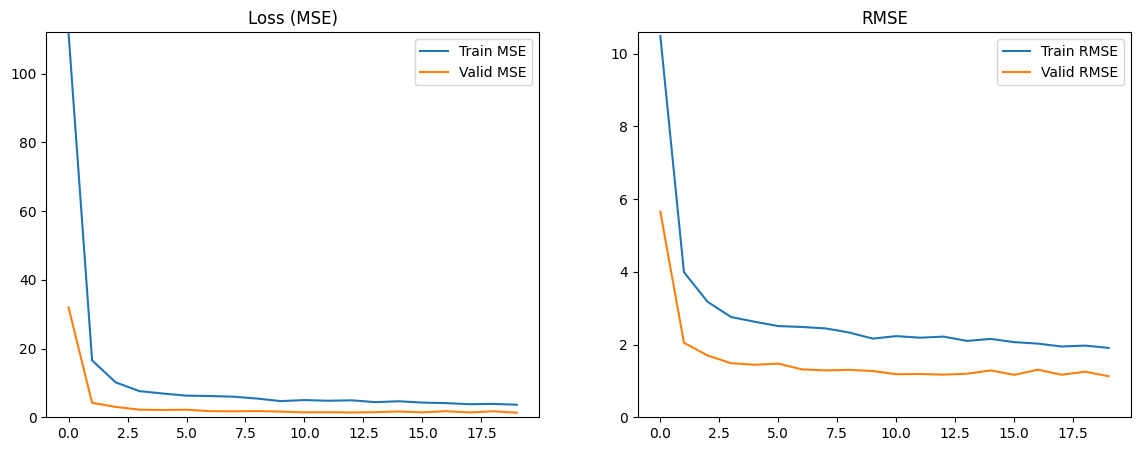

In [79]:
# Обучение прошло, теперь надо визуализировать лоссы и метрики: только по графикам можно понять, обучилась ли модель
plot_loss_metrics(train_losses, valid_losses, train_metric, valid_metric)

In [ ]:
%%sql


6. Измени архитектуру модели и улучши результат: 
    * измени число нейронов
    * попробуй использовать сигмоидную функцию активации: `nn.Sigmoid`
    * измени число слоев
    * поэкспериментируй с активационными функциями и дропаутом

In [205]:
# big_model = nn.Sequential(
#     nn.Linear(n_features, 128),
#     nn.ReLU(),
#     nn.Dropout(p=0.2),
#
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.Dropout(p=0.1),
#
#     nn.Linear(64, 32),
#     nn.ReLU(),
#     nn.Dropout(p=0.05),
#
#     nn.Linear(32, 1)
# )

big_model = nn.Sequential(
    nn.Linear(n_features, 256), nn.BatchNorm1d(256), nn.SiLU(), nn.Dropout(0.2),
    nn.Linear(256, 128),        nn.BatchNorm1d(128), nn.SiLU(), nn.Dropout(0.2),
    nn.Linear(128, 64),         nn.BatchNorm1d(64),  nn.SiLU(), nn.Dropout(0.1),
    nn.Linear(64, 1)
)


In [206]:
criterion = nn.MSELoss()
# optimizer = optim.SGD(big_model.parameters(), lr = 0.01)
optimizer = optim.AdamW(big_model.parameters(), lr=1e-3, weight_decay=1e-3)


Epoch 0 finished: train_mse=152.313, valid_mse=146.820, train_rmse=12.341, valid_rmse=12.117
Epoch 1 finished: train_mse=148.064, valid_mse=146.276, train_rmse=12.168, valid_rmse=12.094
Epoch 2 finished: train_mse=144.081, valid_mse=144.430, train_rmse=12.003, valid_rmse=12.018
Epoch 3 finished: train_mse=140.396, valid_mse=139.820, train_rmse=11.849, valid_rmse=11.825
Epoch 4 finished: train_mse=137.515, valid_mse=135.016, train_rmse=11.727, valid_rmse=11.620
Epoch 5 finished: train_mse=134.404, valid_mse=131.213, train_rmse=11.593, valid_rmse=11.455
Epoch 6 finished: train_mse=131.448, valid_mse=127.160, train_rmse=11.465, valid_rmse=11.276
Epoch 7 finished: train_mse=128.115, valid_mse=124.057, train_rmse=11.319, valid_rmse=11.138
Epoch 8 finished: train_mse=125.161, valid_mse=121.696, train_rmse=11.187, valid_rmse=11.032
Epoch 9 finished: train_mse=122.219, valid_mse=118.628, train_rmse=11.055, valid_rmse=10.891
Epoch 10 finished: train_mse=119.231, valid_mse=115.050, train_rmse=10

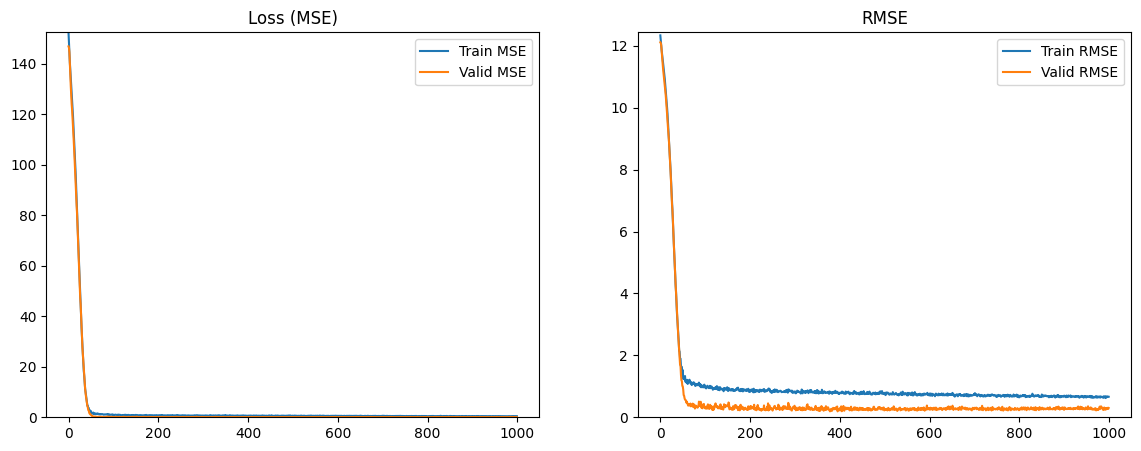

In [207]:
train_losses, valid_losses, train_metric, valid_metric = fit_model(big_model, 1000)
plot_loss_metrics(train_losses, valid_losses, train_metric, valid_metric)

7. Попробуй добиться лучшего результата, чем получалось на прошлой неделе во время выполнения проекта!

In [209]:
sub = predict_and_save_torch(big_model, X_te, test["Id"].values, filename="submission.csv")
sub.head()

Saved: submission.csv


,Id,SalePrice
0,1461,93651.976562
1,1462,142584.312500
2,1463,184660.531250
3,1464,158531.640625
4,1465,194676.031250


## Дополнительное задание

### Классификация клиента банка 

* С помощью `pytorch` классифицировать клиентов банка. 

* Датасет [здесь](https://raw.githubusercontent.com/Anurion/Uralsib_test/main/Uralsib_test/Data.txt)

* Метрика: `f1_score`

* При чтении данных нужно указать аргумент `read_csv()` `encoding='kz1048'`